# Выбор локации для скважины

Для добывающей компании нужно решить, где бурить новую скважину.

В качестве исходных данных -  пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель проекта** - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Для этого необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Необходимые библиотеки

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# импортируем из бибилиотеки sklearn необходимые функции
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# импортируем из бибилиотеки sklearn структуры данных для классификации
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# отключим некритические предупреждения в коде
import warnings
warnings.filterwarnings("ignore")

### Импорт данных. Регион 1

Загрузим каждый регион в отдельный датафрейм.

In [2]:
# чтение файла с данными и сохранение в DataFrame
data_region_one = pd.read_csv('----.csv')
data_region_one.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

In [3]:
data_region_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет, id имеет тип object.

In [4]:
data_region_one.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Во всех колонках медиана почти равна среднему, что может говорить о нормальном распределении данных, посмотрим далее по графикам.

In [5]:
def explore_data(data):
    print(f"Shape: {data.shape}")
    print("Количество пропусков в данных: ", data.isna().sum().sum())
    print("Дубликаты: ", data.duplicated().sum())
    print("\nРаспределение признаков:")
    data[["f0","f1","f2"]].hist()
    plt.show()

Shape: (100000, 5)
Количество пропусков в данных:  0
Дубликаты:  0

Распределение признаков:


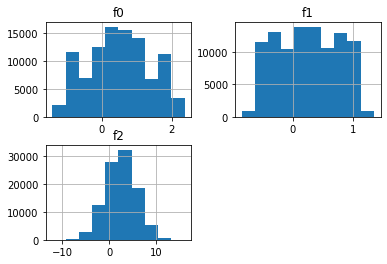

In [6]:
explore_data(data_region_one)

In [7]:
data_region_one.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [8]:
# проверю уникальные значения в 'id'
data_region_one['id'].value_counts()

bsk9y    2
AGS9W    2
fiKDv    2
74z30    2
bxg6G    2
        ..
HYyia    1
dJXdv    1
YNABW    1
LJDRU    1
aJNXI    1
Name: id, Length: 99990, dtype: int64

In [9]:
data_region_one[data_region_one['id'] == 'TtcGQ'].head()

,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


Наименование одно, а данные другие.
Удалим из датафрейма столбец id. Он не несет значимости для модели.

In [10]:
data_region_one = data_region_one.drop(['id'], axis=1)
data_region_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


### Импорт данных. Регион 2

In [11]:
data_region_two = pd.read_csv('----.csv')
data_region_two.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
data_region_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
data_region_two.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


В колонках `f0` и `f1` медиана почти равна среднему, в `f2` и `product` среднее больше медианы, что может говорить о скошенности данных вправо.

Shape: (100000, 5)
Количество пропусков в данных:  0
Дубликаты:  0

Распределение признаков:


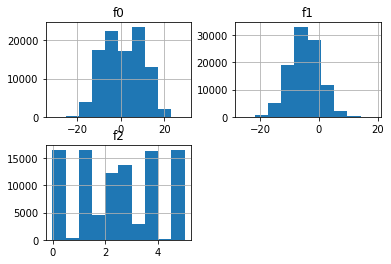

In [14]:
explore_data(data_region_two)

In [15]:
data_region_two.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [16]:
data_region_two = data_region_two.drop(['id'], axis=1)
data_region_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


### Импорт данных. Регион 3

In [17]:
data_region_three = pd.read_csv('----.csv')
data_region_three.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [18]:
data_region_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [19]:
data_region_three.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Данные в `f0` и `f1` похожи между собой. Медиана и средняя близки к нулю, почти такие же только с обратным знаком.
В `f2` и `product` медиана почти равна среднему, что может говорить о нормальном распределении данных.

Shape: (100000, 5)
Количество пропусков в данных:  0
Дубликаты:  0

Распределение признаков:


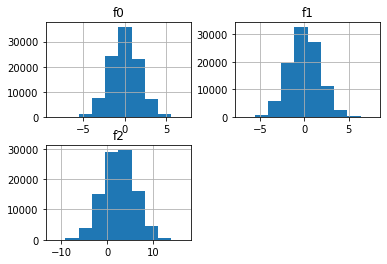

In [20]:
explore_data(data_region_three)

In [21]:
data_region_three.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [22]:
data_region_three = data_region_three.drop(['id'], axis=1)
data_region_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


### Данные о запасах нефти

In [23]:
#Построим графики чтобы посмотреть на распределение
def dist_and_box(df,col,title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'Данные по региону №{title}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'Данные по региону №{title}',fontsize=20);  

In [24]:
def oil_hist_and_box(seria, bins, xlim_max, ylim_max, title, color):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins, color = color)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title(f'Гистограмма распределения по объему скважин в регионе №{title}',fontsize=10)
    plt.show()
    sns.boxplot(seria, color = color, width=1).set_title(f'Распределение запасов нефти в регионе №{title}',
                                                         fontsize=10);  

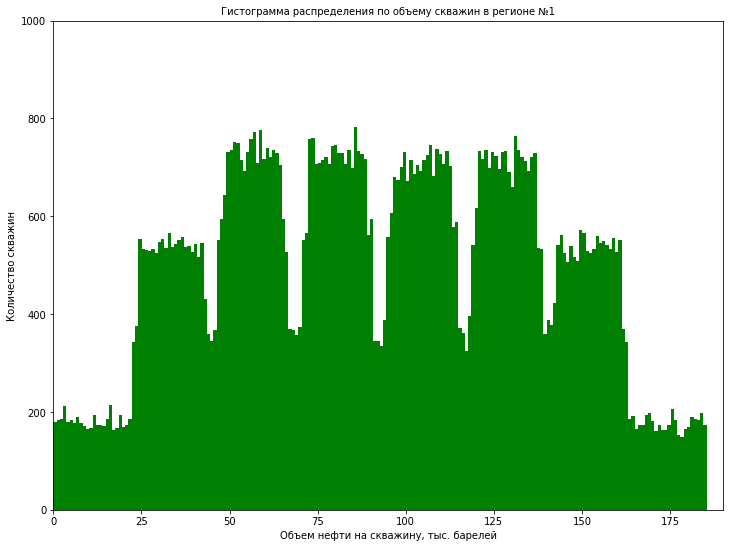

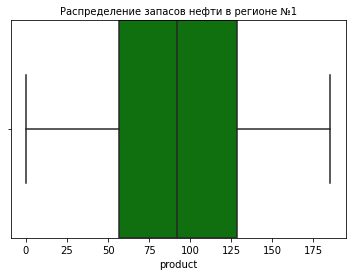

In [25]:
oil_hist_and_box(data_region_one['product'], 200, 190, 1000, 1, 'green')

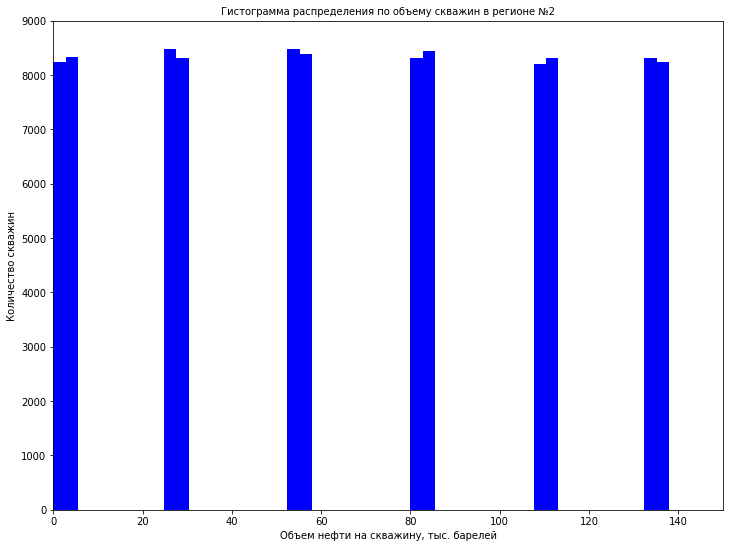

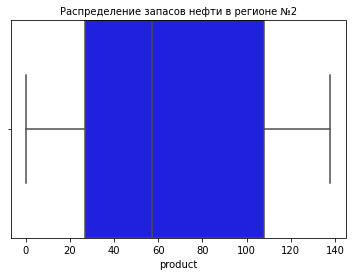

In [26]:
oil_hist_and_box(data_region_two['product'], 50, 150, 9000, 2, 'blue')

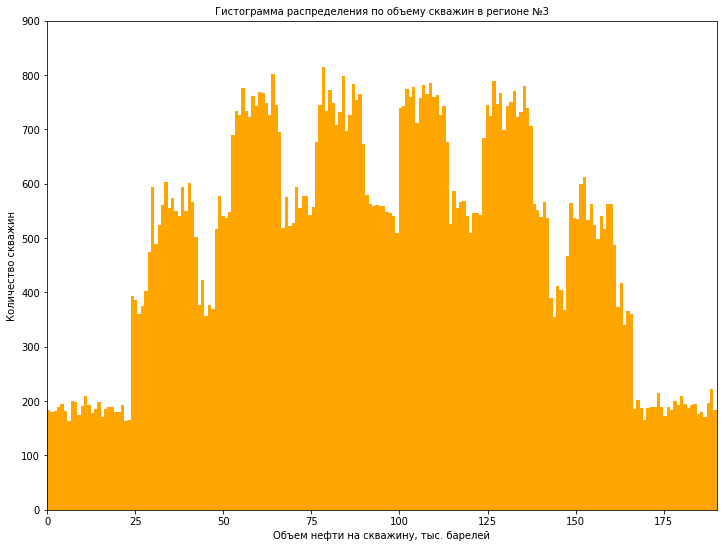

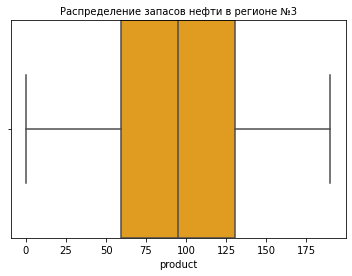

In [27]:
oil_hist_and_box(data_region_three['product'], 200, 190, 900, 3, 'orange')

### Вывод

1. Признаки для модели:

    - `f0`;
    - `f1`;
    - `f2`.

    Целевой признак: `product`.
    
2. Чтобы избежать ошибок, в датасетах были удалены строки с дублирующимися id.
3. По гистограммам можно понять, что у первого и третьего региона наспределение скважин близкое к нормальному. Во втором регионе данные имеют странное распределение: от 0 до 140 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные скорее всего были введены искуственно.

## Обучение и проверка модели

In [28]:

def get_linear_regression_prediction(data):
    
    # выделим признаки
    target = data['product']
    features = data.drop(['product'], axis=1) 
    
    # разобьём данные на тестовую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    
    print(f'Размеры тренировочной и валидационной выборок {features_train.shape} {features_valid.shape}')
    print(f'Размеры целевых признаков теста и валидации {target_train.shape} {target_valid.shape}')
    
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    # обучим модель
    
    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid)
    predicted_valid_series = pd.Series(predicted_valid)
    rmse = (mean_squared_error(predicted_valid_series, target_valid))**(0.5)
    average_product_predicted = sum(predicted_valid_series) / len(predicted_valid_series)
    target_series = pd.Series(target)
    average_product_fact = sum(target_series) / len(target_series)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product predicted: {0:.2f}".format(average_product_predicted))
    print("Average product fact: {0:.2f}".format(average_product_fact))
    
    return (predicted_valid, target_valid,  rmse)

In [29]:
print('Регоин 1')
region_1_predicted, target_valid_1, rmse_1 = get_linear_regression_prediction(data_region_one)
print('Регоин 2')
region_2_predicted, target_valid_2, rmse_2 = get_linear_regression_prediction(data_region_two)
print('Регоин 3')
region_3_predicted, target_valid_3, rmse_3 = get_linear_regression_prediction(data_region_three)

Регоин 1
Размеры тренировочной и валидационной выборок (75000, 3) (25000, 3)
Размеры целевых признаков теста и валидации (75000,) (25000,)
RMSE: 37.58
Average product predicted: 92.59
Average product fact: 92.50
Регоин 2
Размеры тренировочной и валидационной выборок (75000, 3) (25000, 3)
Размеры целевых признаков теста и валидации (75000,) (25000,)
RMSE: 0.89
Average product predicted: 68.73
Average product fact: 68.83
Регоин 3
Размеры тренировочной и валидационной выборок (75000, 3) (25000, 3)
Размеры целевых признаков теста и валидации (75000,) (25000,)
RMSE: 40.03
Average product predicted: 94.97
Average product fact: 95.00


Чем ближе корень из средней квадратичной ошибки (RMSE) к нулю тем лучше.

Наши значения RMSE:

Первый регион: 37.5794 <br>
Второй регион: 0.8931 <br>
Третий регион: 40.0297 <br>

- Средний запас предсказанного сырья практически соответствует средним значениям запасов первоначальных данных;
- Минимальная метрика RMSE достигнута в регионе № 2, хуже всего предсказывает модель региона № 3, RMSE = 40.03;
- Модель № 2, скорее всего, так справилась из-за предварительно сгруппированных данных по запасам (12 подвыборок).


## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных

Вводные для расчета прибыли:

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [30]:
count_of_wells = 200

Бюджет на разработку скважин в регионе — 10 млрд рублей.

In [31]:
budget = 10_000_000_000

Цена одной скважины:

In [32]:
price_one_well = budget / count_of_wells 
price_one_well

50000000.0

 Доход с каждой единицы продукта составляет 450 тыс. рублей.

In [33]:
price_per_barrel  = 450_000

Точка безубыточности

In [34]:
profit_0 = budget / price_per_barrel
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(profit_0))

Точка безубыточности: 22222 тыс. баррелей


In [35]:
one_ceil_volume = profit_0/200
print("Средний объем нефти в скважине для безубыточного функционирования:", one_ceil_volume)

Средний объем нефти в скважине для безубыточного функционирования: 111.11111111111111


In [36]:
def compare_volume(region_volume_mean, region):
    if region_volume_mean < one_ceil_volume:
        print(f'Средний предсказанный запас сырья в регионе {region}')
        print(f'меньше объёма достаточного для безубыточной разработки на {round(one_ceil_volume - region_volume_mean, 2)}')
    else:
        print(f'Средний предсказанный запас сырья в регионе {region}')
        print(f'больше объёма достаточного для безубыточной разработки на {round(region_volume_mean - one_ceil_volume, 2)}')

In [37]:
compare_volume(data_region_one['product'].mean(), 1)
compare_volume(data_region_two['product'].mean(), 2)
compare_volume(data_region_three['product'].mean(), 3)

Средний предсказанный запас сырья в регионе 1
меньше объёма достаточного для безубыточной разработки на 18.61
Средний предсказанный запас сырья в регионе 2
меньше объёма достаточного для безубыточной разработки на 42.29
Средний предсказанный запас сырья в регионе 3
меньше объёма достаточного для безубыточной разработки на 16.11


### Вывод

- Мы сохранили ключевые значения для расчетов в переменных;
- Рассчитали необходимое количество сырья для безубыточной разработки новой скважины - это 111.11 баррелей;
- После сравнения средних предсказанных моделю запасов сырья, мы выяснили что среднее значение запасов во всех трех регионах меньше необходимого количества для безубыточной разработки;
- Ближе всего к необходимому количеству предсказанные запасы в регионе №3, меньше всего предсказанных запасов в регионе №2.

## Расчёт прибыли и рисков 

In [38]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def revenue(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:count_of_wells].index
    selected = target[predictions_s]
    revenue = selected.sum() * price_per_barrel - budget
    return round(revenue, 2)

In [39]:
print('Прибыль региона № 1 (200 лучших скважин): {} млрд.рублей'.format(revenue(target_valid_1, 
                                                                                region_1_predicted) ))
print('Прибыль региона № 2 (200 лучших скважин): {} млрд.рублей'.format(revenue(target_valid_2, 
                                                                                region_2_predicted) ))
print('Прибыль региона № 3 (200 лучших скважин): {} млрд.рублей'.format(revenue(target_valid_3, 
                                                                                region_3_predicted) ))

Прибыль региона № 1 (200 лучших скважин): 3320826043.14 млрд.рублей
Прибыль региона № 2 (200 лучших скважин): 2415086696.68 млрд.рублей
Прибыль региона № 3 (200 лучших скважин): 2710349963.6 млрд.рублей


Исходя из условий задачи исследуем 500 точек, а выбираем 200 лучших. Найдем случайные 500 скважин из всей выборки (1000 раз), из них выберем 200 лучших.

In [40]:
state = np.random.RandomState(12345)
def bootstrap(target, probabilities, iterations, sample_size):
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=sample_size, 
                                         random_state=state, 
                                         replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return round(mean,2),  round(risk*100, 2), quantile_interval

In [41]:
revenue_1_mean, region_1_risk, refion_1_quantile = bootstrap(target_valid_1.reset_index(drop=True), 
                                                             region_1_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', revenue_1_mean)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', refion_1_quantile)
print(f'Регион №1 Риск убытков: {region_1_risk}%')

Регион №1 средняя выручка =  396164984.8
Регион №1 95 %ый доверительный интервал по квантилям =  (-111215545.89, 909766941.5539998)
Регион №1 Риск убытков: 6.9%


In [42]:
revenue_2_mean, region_2_risk, refion_2_quantile = bootstrap(target_valid_2.reset_index(drop=True), 
                                                             region_2_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', revenue_2_mean)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', refion_2_quantile)
print(f'Регион №1 Риск убытков: {region_2_risk}%')

Регион №1 средняя выручка =  461155817.28
Регион №1 95 %ый доверительный интервал по квантилям =  (78050810.74800001, 862952060.26)
Регион №1 Риск убытков: 0.7%


In [43]:
revenue_3_mean, region_3_risk, refion_3_quantile = bootstrap(target_valid_3.reset_index(drop=True), 
                                                             region_3_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', revenue_3_mean)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', refion_3_quantile)
print(f'Регион №1 Риск убытков: {region_3_risk}%')

Регион №1 средняя выручка =  392950475.17
Регион №1 95 %ый доверительный интервал по квантилям =  (-112227625.37975, 934562914.5469998)
Регион №1 Риск убытков: 6.5%


### Вывод

| Регион | RMSE | Среднее фактическое, тыс.баррелей | Среднее предсказанное, тыс.баррелей| Средняя выручка | Риск убытка |
| --- | --- | --- | --- | --- | --- |
| 1 | 37.58 | 92.50 | 92.59 | 391783677.38 | 7.0% |
| 2 | 0.89 | 68.83 | 68.73 | 447095482.79 | 1.2% |
| 3 | 40.03 | 95.00 | 94.97 | 395329259.55 | 5.7% |

Рекомендуется проводить разработку месторождений в регионе №2. 
Согласно прогнозам сделанным с помощью техники Bootstrap, наиболее прибыльным будет разработка месторождений в регионе №2. В данном регионе самые высокие показатели средней выручки и 95%-ного доверительного интервала. Также в регионе №2 самый низкий риск убытков.

## Вывод

1. Провели исследовательский анализ данных, проверили датасеты на наличие пропусков, дупликатов, а также посмотрели на распределения признаков, запасы нефти распределены не нормально.
2. Построили линейную модель, для предсказания объемов нефти в скважинах.
3. Затем мы выполнили процедуру бутстрэпа и нашли 95% доверительный интервал для среднего объема нефти в скважинах. Наиболее перспективным для разработки представляется регион № 2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.